In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score

# 1.데이터 로드


In [4]:
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_Labeled_50.csv')

In [5]:
# df_org 복사 => df
df = df_org.copy()

In [6]:
# df.head(3)
print('기지국 기기 개수 : {}개'.format(df.machine_id.nunique()))

기지국 기기 개수 : 51개


In [7]:
# 수치형 변수 목록
target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

In [8]:
# df[df[target_columns] < 0].isna().sum()

# 2.누락 데이터 보간

In [9]:
# 전체 데이터 shape
df.shape

(61633, 16)

In [10]:
# 시간 변수 생성
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [11]:
df.head(2)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
0,MA1074_4_20210901_0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,7.873696,11.028859,27753.51401,0,2021-09-01 00:00:00
1,MA1074_4_20210901_1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,6.947635,10.664447,19952.83154,0,2021-09-01 01:00:00


## 2.1 시간 기준 키값 생성
- 누락된 시간대를 생성하기 위해, 원본 데이터와 join할 수 있는 고유키 역할의 기준 컬럼(기지국, 시간) 생성

In [12]:
start_date = df['time'].min() # 시작날짜
end_date = df['time'].max() # 끝날짜
print('시작 날짜 : {}'.format(start_date))
print('종료 날짜 : {}'.format(end_date))
time_index = pd.date_range(start_date, end_date, freq='H')
print('전체 시간 인덱스 : {}개 \n{}'.format(len(time_index), time_index))

시작 날짜 : 2021-09-01 00:00:00
종료 날짜 : 2021-10-31 23:00:00
전체 시간 인덱스 : 1464개 
DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2021-10-31 14:00:00', '2021-10-31 15:00:00',
               '2021-10-31 16:00:00', '2021-10-31 17:00:00',
               '2021-10-31 18:00:00', '2021-10-31 19:00:00',
               '2021-10-31 20:00:00', '2021-10-31 21:00:00',
               '2021-10-31 22:00:00', '2021-10-31 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')


## 2.2 중복 행 삭제
- 원본 데이터 중 일부 중복 행(16쌍)이 발견되어 해당 행 모두 삭제
    - 2021년 9월 16일 16시 특정 시간대에 몇몇 기지국에 대해서 동일 데이터가 수집되었음
    - 중복된 행은 `tot_et`컬럼을 제외하고 모두 같은 값을 가지고 있음
    - `tot_et`변수의 range를 고려했을 때, 중복된 행 중 한 개만 골라 삭제할 수 있으나, 전체 6만개 행 중 *26개* 행은 대세에 영향이 없기 때문에 전체 삭제하는 방향으로 결정

In [13]:
# 중복 행 확인
duplicated_row = df[df.duplicated(subset=['machine_id','time'], keep=False)]

print('중복된 행 개수(쌍): {}개'.format(duplicated_row.shape[0]))
duplicated_row.head(4)

중복된 행 개수(쌍): 26개


,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
351,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,322.14424,0,2021-09-16 16:00:00
352,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,37774.06968,0,2021-09-16 16:00:00
8887,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,313.88000,0,2021-09-16 16:00:00
8888,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,68408.51000,1,2021-09-16 16:00:00


In [14]:
print("중복 제거 전 데이터 shape : {}".format(df.shape))
df = df.drop_duplicates(['machine_id', 'time'], keep=False)
print("중복 제거 후 데이터 shape : {}".format(df.shape))

중복 제거 전 데이터 shape : (61633, 17)
중복 제거 후 데이터 shape : (61607, 17)


## 2.3 df와 df_new 조인
- `machine_id`와 `time` 2개 컬럼에 대해 온전한 기준 데이터프레임(`df_new`) 생성
- 이후 원본 데이터(df)와 조인하여 누락된 시간대 복원

In [15]:
# 기준 컬럼(df_new) 생성
df_new = pd.DataFrame()
machine_list = df.machine_id.unique()
for machine in machine_list:
    tmp = pd.DataFrame({
        'machine_id':[machine]*len(time_index),
        'time':time_index})
    df_new = pd.concat([df_new, tmp], axis=0)

In [16]:
print("df_new 크기 : {}".format(df_new.shape))
df_new

df_new 크기 : (74664, 2)


,machine_id,time
0,MA1074_4,2021-09-01 00:00:00
1,MA1074_4,2021-09-01 01:00:00
2,MA1074_4,2021-09-01 02:00:00
3,MA1074_4,2021-09-01 03:00:00
4,MA1074_4,2021-09-01 04:00:00
...,...,...
1459,MA2561_18,2021-10-31 19:00:00
1460,MA2561_18,2021-10-31 20:00:00
1461,MA2561_18,2021-10-31 21:00:00
1462,MA2561_18,2021-10-31 22:00:00


In [17]:
# df_new와 df 조인 (키 값=['machine_id', 'time'])
df_new = df_new.merge(df, on=['machine_id', 'time'], how='left')

In [18]:
df_new.sample(3)

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
25398,MA1355_0,2021-09-22 06:00:00,MA1355_0_20210922_6,20210922.0,6.0,24.70556,41.0,97.45455,97.43590,100.0,23.14788,14.70744,100.7817,8.202506,17.046890,42033.34,0.0
29088,MA1460_7,2021-10-24 00:00:00,MA1460_7_20211024_0,20211024.0,0.0,31.69389,44.0,99.39577,100.00000,100.0,44.60192,30.39593,101.6643,9.267998,9.208886,75488.67,0.0
70362,MA2523_8,2021-09-04 18:00:00,MA2523_8_20210904_18,20210904.0,18.0,28.01500,40.0,99.52096,99.85735,100.0,35.00696,23.04872,102.1481,12.281670,19.976770,38243.81,0.0


## 2.4 y값 imputation
- 새로 채워진 시간대에 대한 y값은 `0` 레이블로 대체
 - <font color=yellow>해당 시간대에 대한 이상 판단 여부가 불확실하기 때문에 임의의 값으로 채우는 것보다 0으로 채우는 것이 안전하다고 판단</font>

In [19]:
# 누락된 y레이블은 0으로 대체
df_new['y'] = df_new['y'].fillna(0)

In [20]:
df_new.iloc[[3],:]

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [21]:
# machine_list = df_new['machine_id'].unique()
# df_new['year'] = df_new['time'].dt.year # 년
# df_new['month'] = df_new['time'].dt.month # 월

# for idx, machine in enumerate(machine_list):
#     print(df_new.loc[df_new['machine_id'] == machine].groupby(['year', 'month']).size())

# 3.데이터 전처리
- 전체 51개의 기지국 기기 중 랜덤하게 10개 샘플링하여 테스트 진행

## 3.1 샘플링

In [22]:
# 랜덤하게 10개 기기 선택
random_machine = list(np.random.choice(df_new.machine_id.unique(),2, replace=False))

In [23]:
print(random_machine)

['MA1651_7', 'MA1236_1']


In [24]:
# 10개 기기에 대한 데이터만 샘플링
df_test = df_new.loc[df_new['machine_id'].apply(lambda x: x in random_machine), :].reset_index(drop=True)

In [25]:
# 샘플링 결과 검증
df_test.shape, 10 * 61 * 24

((2928, 17), 14640)

In [26]:
df_test.head()

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
0,MA1236_1,2021-09-01 00:00:00,MA1236_1_20210901_0,20210901.0,0.0,22.80222,38.0,100.00000,100.00000,100.0,38.04054,22.935040,100.8364,10.200420,13.130710,40347.29,0.0
1,MA1236_1,2021-09-01 01:00:00,MA1236_1_20210901_1,20210901.0,1.0,19.09944,31.0,100.00000,98.78049,100.0,33.92089,12.966350,102.5064,8.315700,10.312380,36405.68,0.0
2,MA1236_1,2021-09-01 02:00:00,MA1236_1_20210901_2,20210901.0,2.0,14.36278,28.0,100.00000,100.00000,100.0,16.04617,8.038165,102.9326,7.067857,8.953343,17421.54,0.0
3,MA1236_1,2021-09-01 03:00:00,MA1236_1_20210901_3,20210901.0,3.0,13.41000,23.0,100.00000,100.00000,100.0,18.29040,7.333912,107.0000,7.273122,10.930000,32314.15,0.0
4,MA1236_1,2021-09-01 04:00:00,MA1236_1_20210901_4,20210901.0,4.0,13.06389,24.0,91.66667,100.00000,100.0,15.67713,4.905206,104.8666,6.489078,11.961080,17862.57,0.0


- 보간 시 음수로 채워진 값들은 0으로 변환
- 아래 그림과 같이 대부분의 변수에서 음수는 유효하지 않음
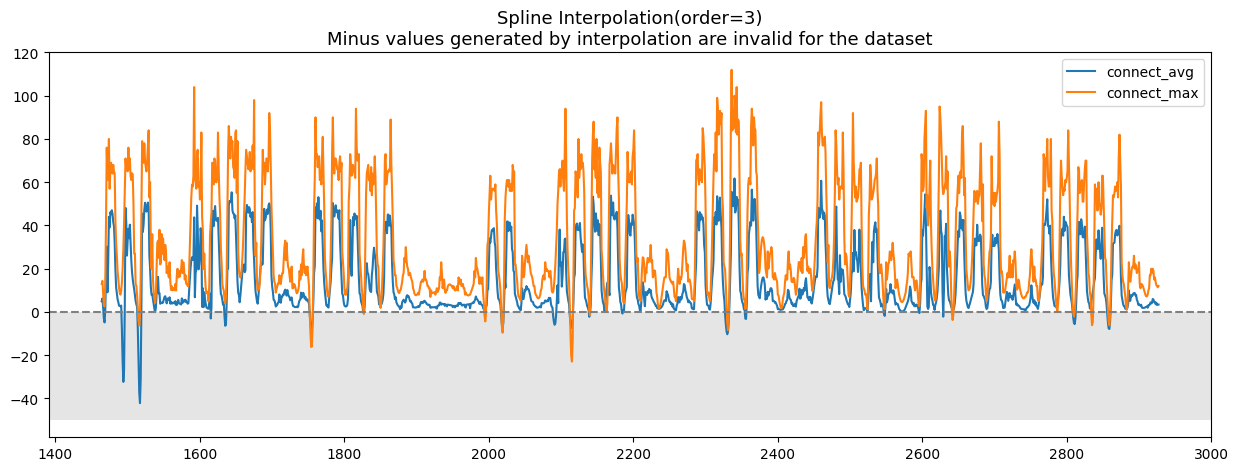

## 3.2 보간/로그차분/파생변수

In [27]:
%%time
import holidays
from datetime import date

def preprocessing(df):
    # 보간&차분 적용 대상 컬럼 선정
    target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']
    # 기지국 고유 id 리스트
    machine_list = df['machine_id'].unique()

    for idx, machine in enumerate(machine_list):
        # spline3로 결측치 보간 후 bfill로 나머지 결측치 채우기
        tmp = df.loc[df['machine_id'] == machine, target_columns].interpolate(method='spline', order=3).bfill()
        tmp[tmp < 0] = 0 # 음수값으로 보간된 수치에 대해서는 0으로 변환
        tmp = np.log1p(tmp).diff(periods=24, axis=0) # 로그 차분 24시간 적용, 0값 고려 log1p 적용
        df.loc[df['machine_id'] == machine, target_columns] = tmp # 변경된 값으로

    df = df.dropna(axis=0, subset=target_columns).reset_index(drop=True) # 로그 차분 결과 발생한 nan 행 제거

    # 시간 파생변수 생성
    df['year'] = df['time'].dt.year # 년
    df['month'] = df['time'].dt.month # 월
    df['day'] = df['time'].dt.day # 일
    df['hour'] = df['time'].dt.hour # 시간
    df['dayofweek'] = df['time'].dt.dayofweek # 요일
    df['is_weekend'] = df['dayofweek'].apply(lambda x : 1 if x >= 5 else 0) # 주중/주말
    df['is_night'] = df['hour'].apply(lambda x : 1 if x >= 23 or x <= 7 else 0) # 주간/야간
    df['is_commute'] = df['hour'].apply(lambda x : 1 if (x >= 7 and x <= 9) or (x >= 17 and x <= 19) else 0)

    # cyclical encoding
    df['day_sin'] = np.sin(df['day'] / 31 * 2 * np.pi)
    df['day_cos'] = np.cos(df['day'] / 31 * 2 * np.pi)

    df['dayofweek_sin'] = np.sin(df['dayofweek'] / 7 * 2 * np.pi)
    df['dayofweek_cos'] = np.cos(df['dayofweek'] / 7 * 2 * np.pi)

    df['hour_sin'] = np.sin(df['hour'] / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['hour'] / 24 * 2 * np.pi)

    # 휴일 컬럼
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['time'].apply(lambda x : 1 if x in kr_holidays else 0)

    # 기지국 파생변수 생성
    df['station'] = df['machine_id'].apply(lambda x : x.split('_')[0])
    return df

df_try = df_new.copy() # 원본 수정 없이 반복적으로 테스트 시행을 위해 df_try에 copy
df_processed = preprocessing(df_try)
df_processed

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

CPU times: user 1min 6s, sys: 111 ms, total: 1min 6s
Wall time: 1min 18s


,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,...,is_night,is_commute,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,is_holiday,station
0,MA1074_4,2021-09-02 00:00:00,MA1074_4_20210902_0,20210902.0,0,-0.016140,0.058841,-0.003187,0.000000,0.000000,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.000000,1.000000,0,MA1074
1,MA1074_4,2021-09-02 01:00:00,MA1074_4_20210902_1,20210902.0,1,-0.040375,-0.039221,-0.381298,0.004795,0.006286,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.258819,0.965926,0,MA1074
2,MA1074_4,2021-09-02 02:00:00,NaN,NaN,2,0.060340,-0.163080,-0.067532,0.005599,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.500000,0.866025,0,MA1074
3,MA1074_4,2021-09-02 03:00:00,MA1074_4_20210902_3,20210902.0,3,0.226949,-0.007034,0.003485,-0.000007,0.001350,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.707107,0.707107,0,MA1074
4,MA1074_4,2021-09-02 04:00:00,NaN,NaN,4,0.175298,0.090093,-0.077281,-0.000262,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.866025,0.500000,0,MA1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73435,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19,-0.126192,-0.147636,-0.001250,0.006266,0.000000,...,0,1,-2.449294e-16,1.000000,-0.781831,0.623490,-0.965926,0.258819,0,MA2561
73436,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20,-0.093788,0.133531,0.003230,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.866025,0.500000,0,MA2561
73437,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21,0.408807,0.241162,0.004017,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.707107,0.707107,0,MA2561
73438,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22,0.177838,0.168623,0.003581,-0.004771,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.500000,0.866025,0,MA2561


In [28]:
# df_processed[['connect_avg', 'connect_max']].plot(kind='line', figsize=(15,5))
# plt.title('Spline Interpolation(order=3)\nMinus values generated by interpolation are invalid for the dataset', fontsize=13)
# plt.axhline(0, linestyle='--', color='grey')
# ax = plt.gca()
# ymin, ymax = ax.get_ylim()
# plt.axhspan(ymin, 0, facecolor='grey', alpha=0.2)
# plt.show()

In [29]:
df.y.value_counts()/df.shape[0],\
df_processed.y.value_counts()/df_processed.shape[0]

(0    0.850439
 1    0.149561
 Name: y, dtype: float64,
 0.0    0.876974
 1.0    0.123026
 Name: y, dtype: float64)

## 3.3 분리/스케일링/인코딩

In [51]:
def split_scaling_encoding(df, preprocessing=False, to_automl=False):
    X = df.drop(['ckey', 'date', 'time', 'y'], axis=1)
    y = df['y']

    categorical_columns = ['station', 'machine_id', 'year', 'month']
    numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']


    preprocessor = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (OneHotEncoder(sparse_output=False), categorical_columns),
    )

    if not to_automl: # to_automl이 False인 경우 분리, 스케일링, 인코딩 처리
        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

        if not preprocessing:
            return X_train, X_test, y_train, y_test
        else:
            X_train_processed = preprocessor.fit_transform(X_train)
            X_test_processed = preprocessor.transform(X_test)
            return X_train_processed, X_test_processed, y_train, y_test, preprocessor

    else: # to_automl이 True인 경우 X, y만 분리 후 return
        return X, y

X_train_p, X_test_p, y_train, y_test, preprocessor = split_scaling_encoding(df_processed, preprocessing=True, to_automl=False)

# X, y = split_scaling_encoding(df_processed, preprocessing=False, to_automl=True)

In [52]:
X_train_p.shape

(58752, 113)

In [53]:
X_train_p

array([[ 2.53627506e-01,  4.70986016e-03,  1.11204124e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-5.26323809e-01,  2.65655236e-01,  4.12705588e-02, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-4.63429478e-01, -4.66715228e-01, -1.74887455e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 5.94809942e-03,  4.70986016e-03,  1.88183393e+01, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.93366573e-01,  6.22131441e-02, -3.00687258e-02, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.57257249e-01, -1.53449684e+00, -7.74345827e-02, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [61]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

train_normal = X_train_p[(y_train == 0).index]
train_anomaly = X_train_p[(y_train != 0).index]

In [74]:
train_normal.shape, train_anomaly.shape, y_train.shape, X_test_p.shape, y_test.shape

((58752, 113), (58752, 113), (58752,), (14688, 113), (14688,))

# 4.Autoencoder

In [32]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

In [56]:
def AE():
    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(Dense(64, input_shape=(113,)))  # 입력계층
    model.add(Activation('relu'))

    model.add(Dense(16))                       # 은닉계층
    model.add(Activation('relu'))

    ## Decoder 구간
    model.add(Dense(16))                        # 은닉계층
    model.add(Activation('relu'))

    model.add(Dense(113))                # 출력계층
    model.add(Activation('linear'))

    return model

In [57]:
# model 함수 실행
model = AE()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7296      
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 113)               1

In [59]:
# 모델 구조 확정하고 컴파일 진행
model.compile(loss='MSE',                   # MSE : mean square error
              optimizer='adam',
              metrics=[ 'mse' ])            # MAE : mean absolute  error

# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(train_normal, train_normal,
                    batch_size=256,
                    epochs=100,
                    validation_data=(train_anomaly, train_anomaly),
                    shuffle=True)

Epoch 1/100
230/230 [==============================] - 4s 9ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 2/100
230/230 [==============================] - 2s 8ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 3/100
230/230 [==============================] - 1s 6ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 4/100
230/230 [==============================] - 2s 7ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 5/100
230/230 [==============================] - 1s 7ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 6/100
230/230 [==============================] - 1s 6ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 7/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 8/100
230/230 [==============================] - 1s 4ms/step - 

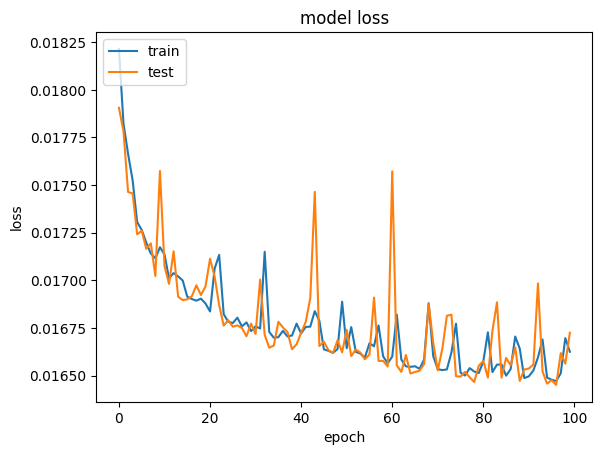

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1836/1836 [==============================] - 4s 2ms/step
Normal Metric
         Normal_mse
count  58752.000000
mean       0.016725
std        0.021611
min        0.006451
25%        0.017190
50%        0.017337
75%        0.017513
max        3.080423


1836/1836 [==============================] - 2s 1ms/step
Anomaly Metric
        Anomaly_mse
count  58752.000000
mean       0.016725
std        0.021611
min        0.006451
25%        0.017190
50%        0.017337
75%        0.017513
max        3.080423




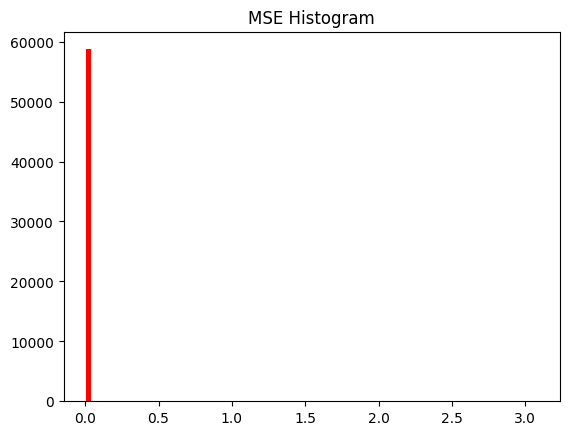

In [71]:
import pandas as pd # pandas 라이브러리

# Normal data (data_3000)
train_normal_reconstruction = model.predict(train_normal) # AE 이미지 결과값
Nom_pred_mse = np.mean(np.power(train_normal - train_normal_reconstruction, 2), axis=1) # input - output 이미지간의 MSE 구하기


# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

print('\n')

# Abnormal data (data_1000)
train_anomaly_reconstruction = model.predict(train_anomaly) # AE 이미지 결과값
ANom_pred_mse = np.mean(np.power(train_anomaly - train_anomaly_reconstruction, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

# 히스토그램 그리기
print('\n')
plt.figure()
plt.title('MSE Histogram') # 그림 이름 설정
plt.hist(Nom_pred_mse, bins=100, facecolor='blue') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.hist(ANom_pred_mse, bins=100, facecolor='red') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.show()